In [62]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


###Importing the necessary libraries

In [1]:
import os
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.datasets as datasets
from torchvision.utils import make_grid
import torch.optim as optim
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import numpy as np
from PIL import Image
import torchvision.datasets.utils as dataset_utils
import torch.utils.data as data

###Defining the CNN model architecture

In [3]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN,self).__init__()
    self.conv1=nn.Conv2d(3,32,3,padding=1)
    self.bn1=nn.BatchNorm2d(32)
    self.conv2=nn.Conv2d(32,64,3,padding=1)
    self.bn2=nn.BatchNorm2d(64)
    self.conv3=nn.Conv2d(64,128,3,padding=1)
    self.maxpool=nn.MaxPool2d(kernel_size=2,stride=2)
    self.bn3=nn.BatchNorm2d(128)
    self.act=nn.LeakyReLU()
    self.fc1=nn.Linear(128*16*16,256)
    self.fc2=nn.Linear(256,128)
    self.fc3=nn.Linear(128,10)

  def forward(self,x):
    x=self.conv1(x)
    x=self.bn1(x)
    x=self.act(x)
    x=self.conv2(x)
    x=self.bn2(x)
    x=self.act(x)
    x=self.conv3(x)
    x=self.bn3(x)
    x=self.maxpool(x)
    x=self.act(x)
    x=x.reshape(x.size(0),-1)
    # x = torch.flatten(x, 1)
    x=self.fc1(x)
    x=self.fc2(x)
    x=self.fc3(x)
    return x

In [4]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
num_epochs = 10#
batch_size = 64
learning_rate = 0.001

###Resizing the images to 32x32 as the SVHN dataset is of size 32x32 whereas the MNIST and colored MNIST are of size 28x28.We do so to pass them through a common CNN architecture that is defined above

In [6]:
# Defining the data transformations and normalizations

transform = transforms.Compose(
    [transforms.Resize((32,32)),
     transforms.Grayscale(num_output_channels=3),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [7]:
trainset_MNIST=torchvision.datasets.MNIST(root='./data',train=True,download=True,transform=transform)
testset_MNIST=torchvision.datasets.MNIST(root='./data',train=False,download=True,transform=transform)

# Select 10000 random images from the training set
trainset_MNIST= data.random_split(trainset_MNIST, [10000, len(trainset_MNIST) - 10000])[0]
testset_MNIST= data.random_split(testset_MNIST, [5000, len(testset_MNIST) - 5000])[0]



trainloader_MNIST = torch.utils.data.DataLoader(trainset_MNIST, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testloader_MNIST = torch.utils.data.DataLoader(testset_MNIST, batch_size=batch_size,
                                          shuffle=False, num_workers=2)

100%|██████████| 9912422/9912422 [00:00<00:00, 75232318.21it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 105980484.54it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 20862983.90it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 7089887.89it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [8]:
def show_images(dataloader):
    # Get the first batch of images and labels
    images, labels = next(iter(dataloader))
    images, labels = images[:12], labels[:12]
    # Denormalize the pixel values
    images = images / 2 + 0.5

    # Set the number of images per row
    num_images_per_row = 3

    # Calculate the number of rows required
    num_rows = int(np.ceil(images.shape[0] / num_images_per_row))

    # Create a figure and axes for the subplots
    fig, axs = plt.subplots(num_rows, num_images_per_row, figsize=(16, 16))

    # Loop over the images and display each one
    for i in range(images.shape[0]):
        # Convert the image tensor to a numpy array
        img_np = images[i].numpy()

        # Transpose the array to match matplotlib format (H x W x C)
        img_np = np.transpose(img_np, (1, 2, 0))

        # Calculate the row and column index for the subplot
        row_idx = i // num_images_per_row
        col_idx = i % num_images_per_row

        # Display the image in the corresponding subplot
        axs[row_idx, col_idx].imshow(img_np)
        axs[row_idx, col_idx].axis('off')

        # Print the corresponding label
        axs[row_idx, col_idx].set_title(f'Label: {labels[i].item()}')

    # Adjust the spacing between the subplots
    plt.subplots_adjust(wspace=0.1, hspace=0.4)

    # Display the figure
    plt.show()

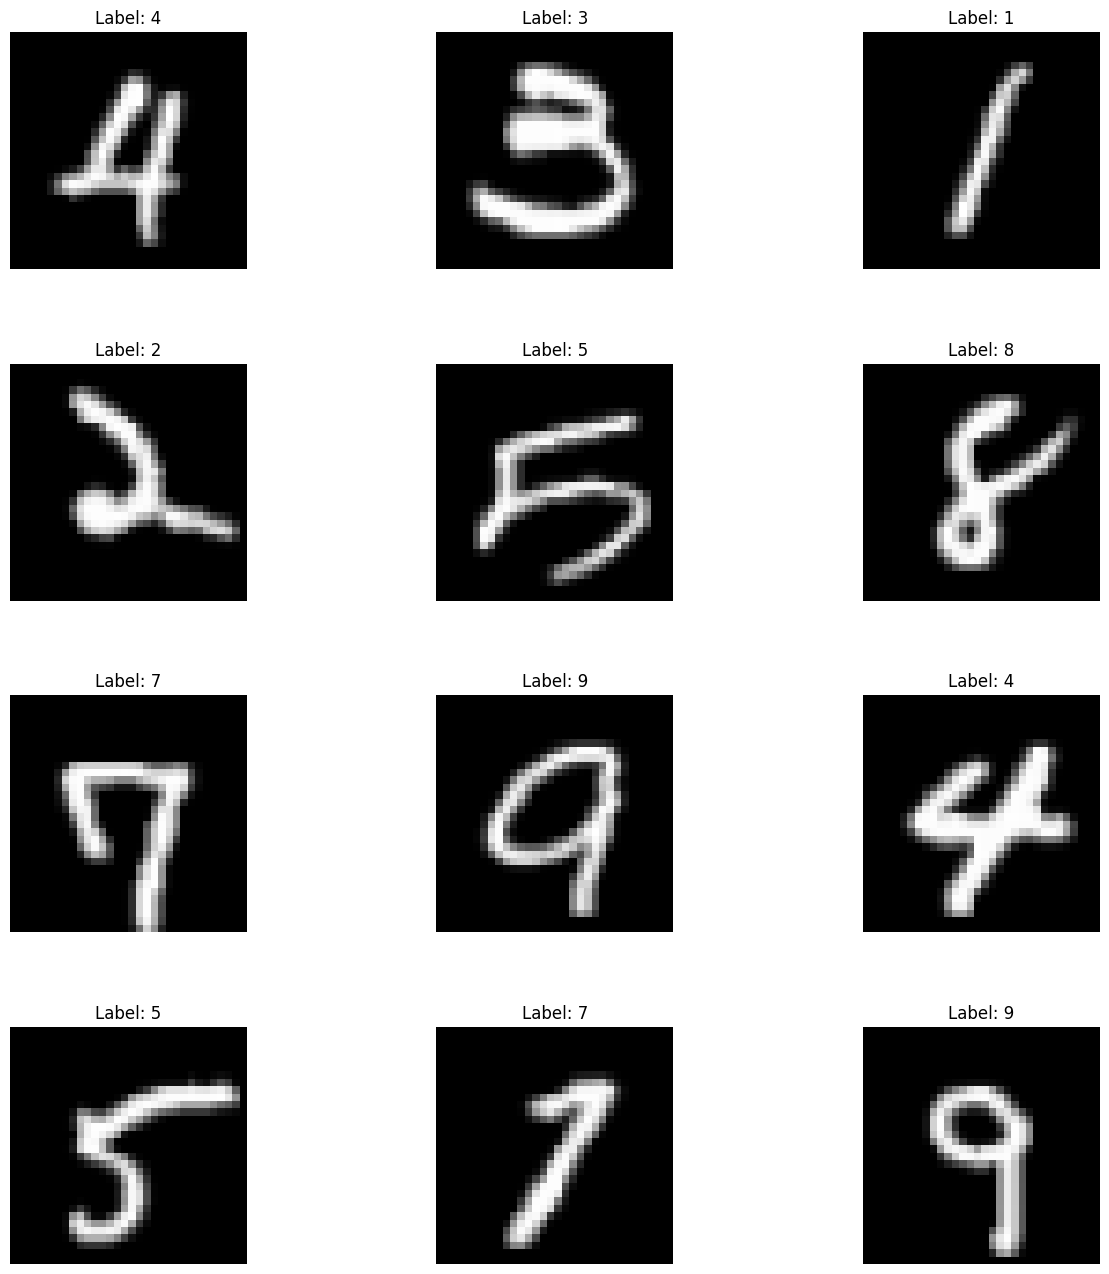

In [9]:
show_images(trainloader_MNIST)

In [10]:
transform = transforms.Compose(
    [
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset_SVHN=torchvision.datasets.SVHN(root='./data',split='train',download=True,transform=transform)
testset_SVHN=torchvision.datasets.SVHN(root='./data',split='test',download=True,transform=transform)

trainset_SVHN= data.random_split(trainset_SVHN, [10000, len(trainset_SVHN) - 10000])[0]
testset_SVHN= data.random_split(testset_SVHN, [5000, len(testset_SVHN) - 5000])[0]


trainloader_SVHN = torch.utils.data.DataLoader(trainset_SVHN, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testloader_SVHN = torch.utils.data.DataLoader(testset_SVHN, batch_size=batch_size,
                                          shuffle=False, num_workers=2)

Using downloaded and verified file: ./data/train_32x32.mat
Using downloaded and verified file: ./data/test_32x32.mat


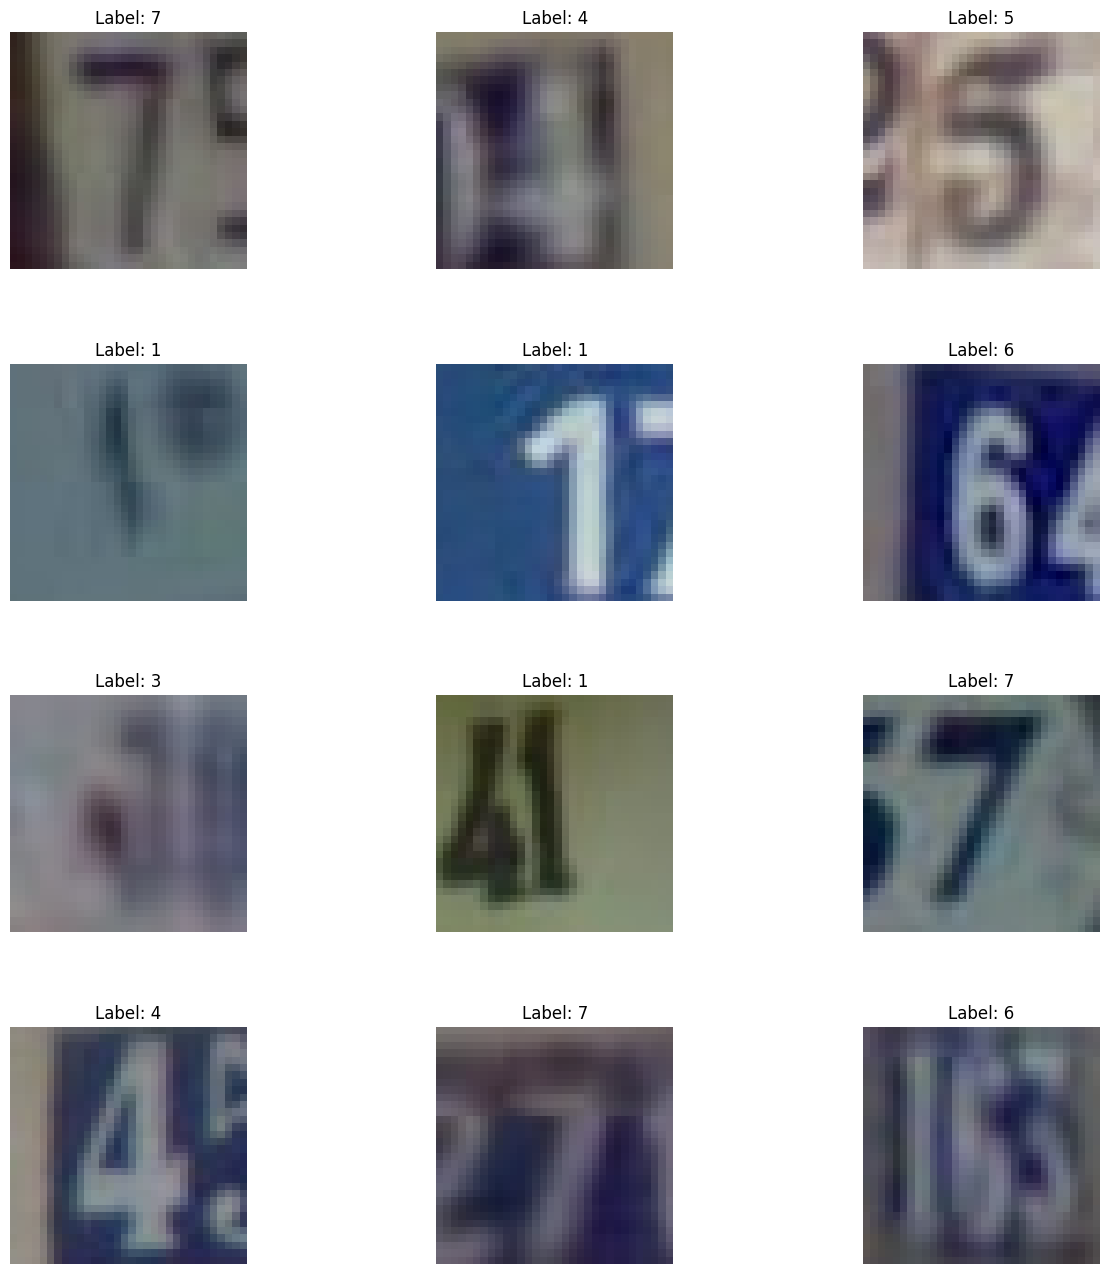

In [11]:
show_images(trainloader_SVHN)

###Loading the colored MNIST


In [12]:
import torch
from torchvision import datasets, transforms

# # Load the MNIST dataset
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)
mnist_testset=datasets.MNIST(root='./data',train=False,download=True,transform=None)

# Define a color transform to randomly colorize the grayscale images
color_transform = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)), # repeat grayscale image 3 times to get 3 channels
    transforms.RandomApply([
        transforms.Lambda(lambda x: x *torch.randn(3,1,1)), # multiply each channel with a random number
    ], p=0.5),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # normalize the pixel values
])

# Create the Colored MNIST dataset by applying the color transform to each image
trainset_CMNIST = [(color_transform(img), target) for img, target in mnist_trainset]
testset_CMNIST = [(color_transform(img),target) for img,target in mnist_testset]

trainset_CMNIST= data.random_split(trainset_CMNIST, [10000, len(trainset_CMNIST) - 10000])[0]
testset_CMNIST= data.random_split(testset_CMNIST, [5000, len(testset_CMNIST) - 5000])[0]


In [13]:
trainloader_CMNIST=torch.utils.data.DataLoader(trainset_CMNIST ,batch_size=64,shuffle=True, num_workers=2)
testloader_CMNIST=torch.utils.data.DataLoader(testset_CMNIST, batch_size=64,shuffle=False, num_workers=2)

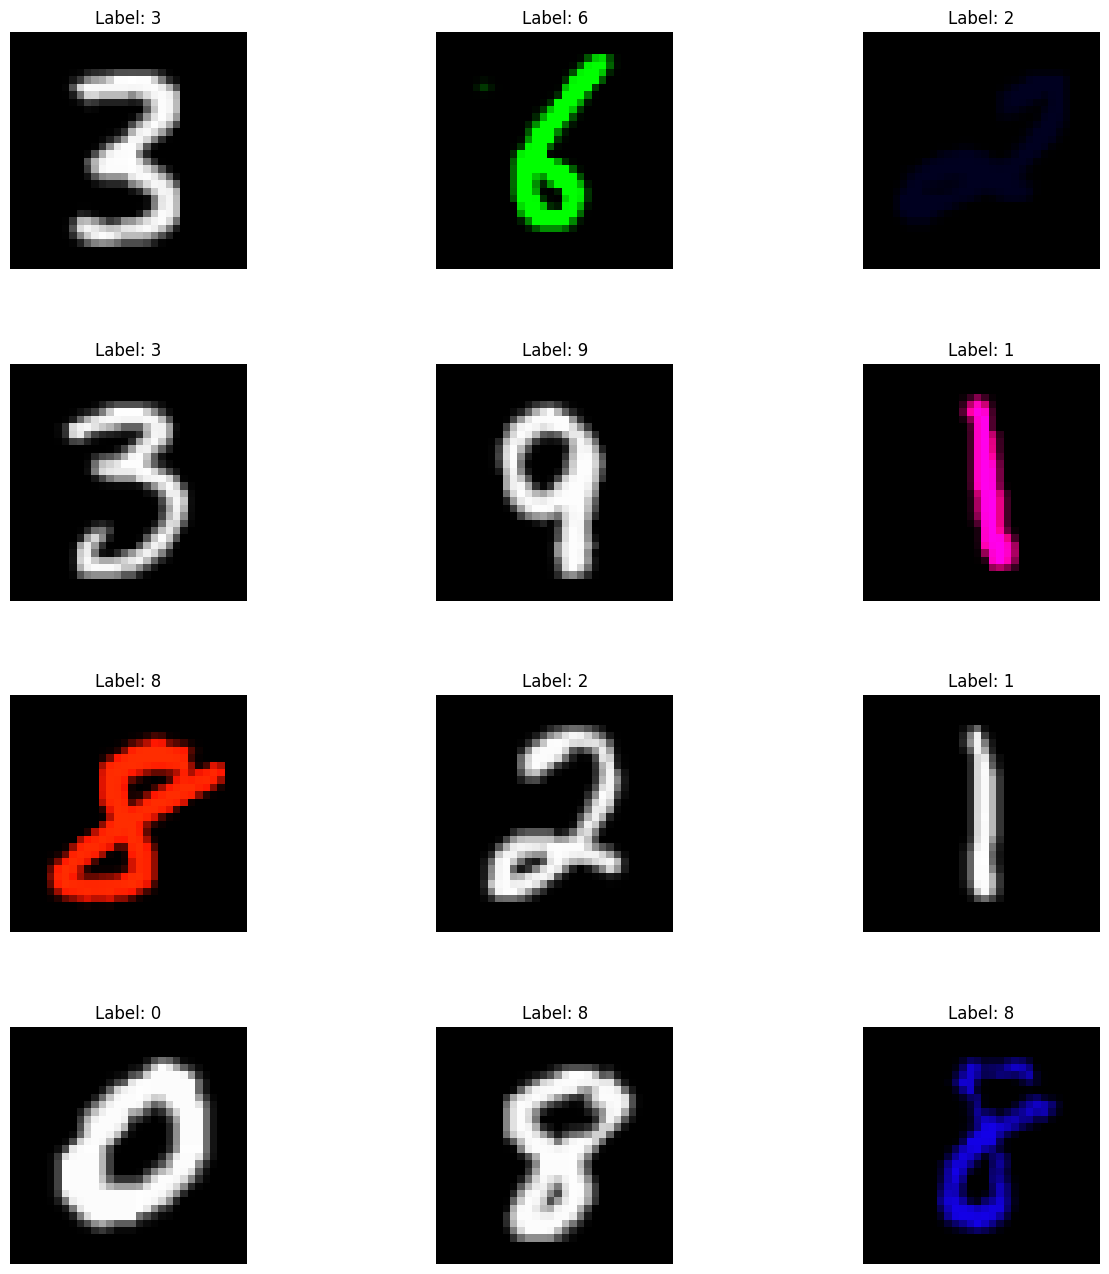

In [ ]:
show_images(trainloader_CMNIST)

###Creating a combined trainloader and testloader containing the mixture of all 

In [14]:
trainset=trainset_MNIST+trainset_CMNIST+trainset_SVHN
testset=testset_MNIST+testset_CMNIST+testset_SVHN

In [15]:
trainloader=torch.utils.data.DataLoader(trainset,batch_size=64,shuffle=True, num_workers=2)
testloader=torch.utils.data.DataLoader(testset, batch_size=64,shuffle=False, num_workers=2)

In [16]:
def plot_loss(l1,l2,l3,epochs):
  x=np.arange(1,epochs+1)
  plt.figure(figsize=(12,8))
  sns.set_context('notebook')
  plt.plot(x,l1,label='Loss curve of client model 1')
  plt.plot(x,l2,label='Loss curve of client model 2')
  plt.plot(x,l3,label='Loss curve of client model 3')
  plt.legend()
  plt.xlabel('Epochs',fontsize=15)
  plt.ylabel('Loss Values',fontsize=15)
  plt.xticks(range(1,epochs+1))
  plt.title('Loss curves for the three client models',fontsize=20)

In [17]:
def plot_cm(confusion_matrix, classes):
    sns.set_context('notebook')
    plt.figure(figsize=(len(classes), len(classes)))
    sns.set(font_scale=1.4)
    sns.heatmap(confusion_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()

In [18]:
criterion=nn.CrossEntropyLoss()

In [19]:
def update_client(client_model,optimizer,train_loader,num_epochs=5):
  client_model.train()
  client_loss=[]
  for e in range(num_epochs):
    running_loss=0
    for batch_idx,(data,target) in enumerate(train_loader):
      data,target=data.to(device),target.to(device)
      client_model.zero_grad()
      output=client_model(data)
      loss=criterion(output,target)
      running_loss+=loss.item()
      loss.backward()
      optimizer.step()
    client_loss.append(running_loss)
  return loss.item(),client_loss


In [20]:
def aggregate_loss(central_server, client_models):
    # Create a list of state dictionaries for all client models
    client_dicts = [model.state_dict() for model in client_models]
    
    # Aggregate the parameters of all client models by taking the mean
    new_dict = {}
    for k in central_server.state_dict():
        new_dict[k] = torch.stack([client_dicts[i][k].float() for i in range(len(client_dicts))], 0).mean(0)
    
    # Load the aggregated parameters to the global model
    central_server.load_state_dict(new_dict)
    
    # Load the aggregated parameters to all client models
    for model in client_models:
        model.load_state_dict(new_dict)

In [21]:
def test(central_server, test_loader,num_classes):
    central_server.eval()
    test_loss = 0
    correct = 0
    confusion_matrix = np.zeros((num_classes, num_classes))
    with torch.no_grad():
        for data, target in test_loader:
            data,target=data.to(device),target.to(device)
            output = central_server(data)
            test_loss += criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            for t, p in zip(target.view(-1), pred.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

    test_loss /= len(test_loader.dataset)
    overall_acc = correct / len(test_loader.dataset)
    classwise_acc = confusion_matrix.diagonal() / confusion_matrix.sum(axis=1)

    return test_loss, overall_acc, classwise_acc,confusion_matrix

In [69]:
num_clients = 3
epochs = 7
batch_size =64
num_rounds=10

In [70]:
central_server=CNN().to(device)
client_models = [CNN().to(device) for _ in range(num_clients)]

In [71]:
for model in client_models:
    model.load_state_dict(central_server.state_dict())

In [72]:
opt = [optim.Adam(model.parameters(), lr=0.001) for model in client_models]

In [73]:
train_loader=[trainloader_MNIST,trainloader_SVHN,trainloader_CMNIST]
test_loader=[testloader_MNIST,testloader_SVHN,testloader_CMNIST]

##A.Perform (0-9) digit classification task using federated setup by performing aggregation at the central server. 

Training the model with MNIST dataset
Training the model with SVHN dataset
Training the model with Colored MNIST dataset
Training the model with MNIST dataset
Training the model with SVHN dataset
Training the model with Colored MNIST dataset
Training the model with MNIST dataset
Training the model with SVHN dataset
Training the model with Colored MNIST dataset
Training the model with MNIST dataset
Training the model with SVHN dataset
Training the model with Colored MNIST dataset
Training the model with MNIST dataset
Training the model with SVHN dataset
Training the model with Colored MNIST dataset
Training the model with MNIST dataset
Training the model with SVHN dataset
Training the model with Colored MNIST dataset
Training the model with MNIST dataset
Training the model with SVHN dataset
Training the model with Colored MNIST dataset
Training the model with MNIST dataset
Training the model with SVHN dataset
Training the model with Colored MNIST dataset
Training the model with MNIST da

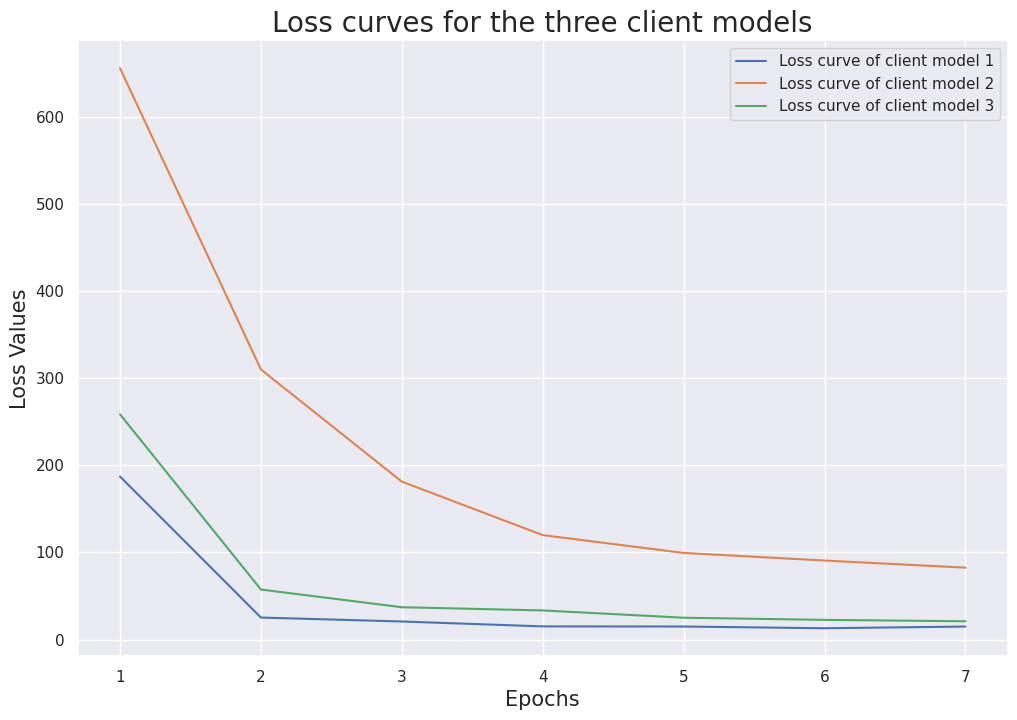

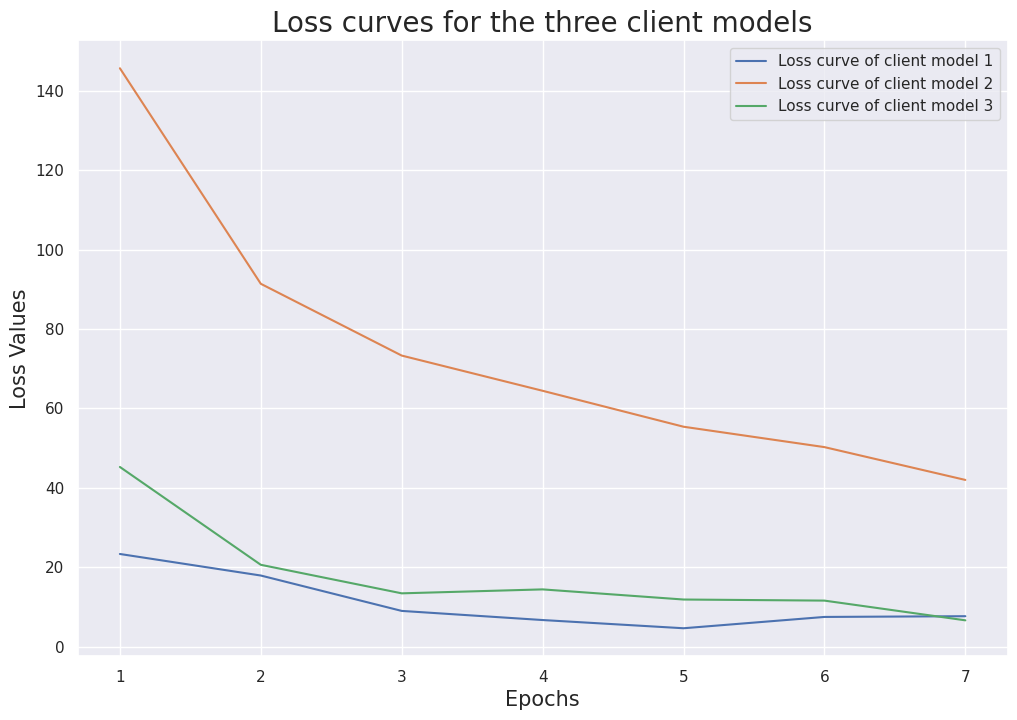

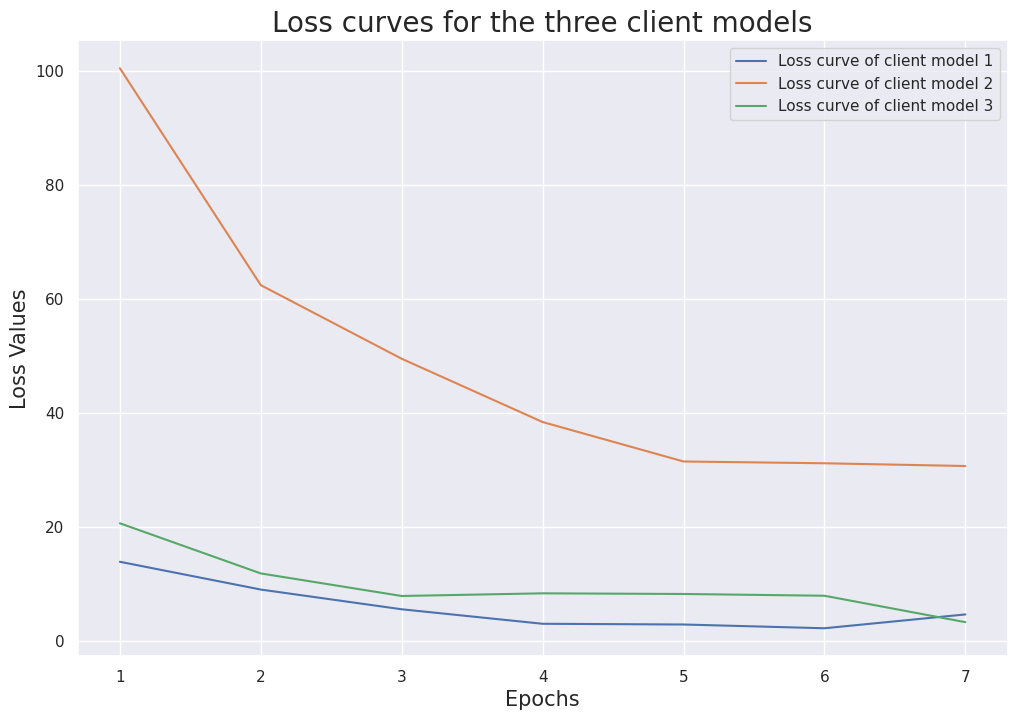

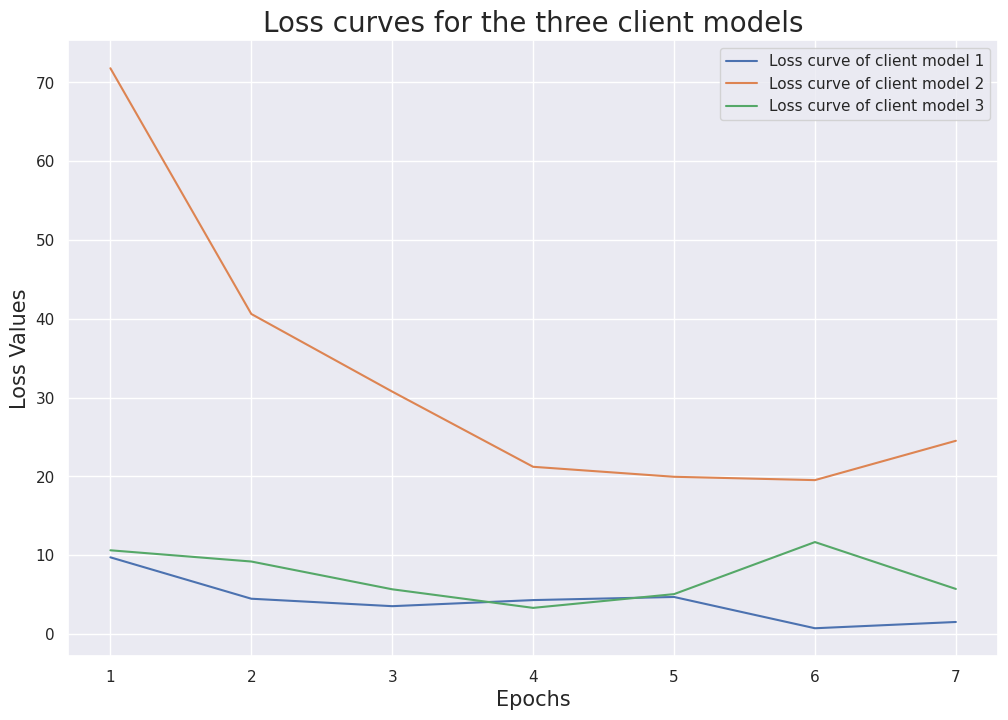

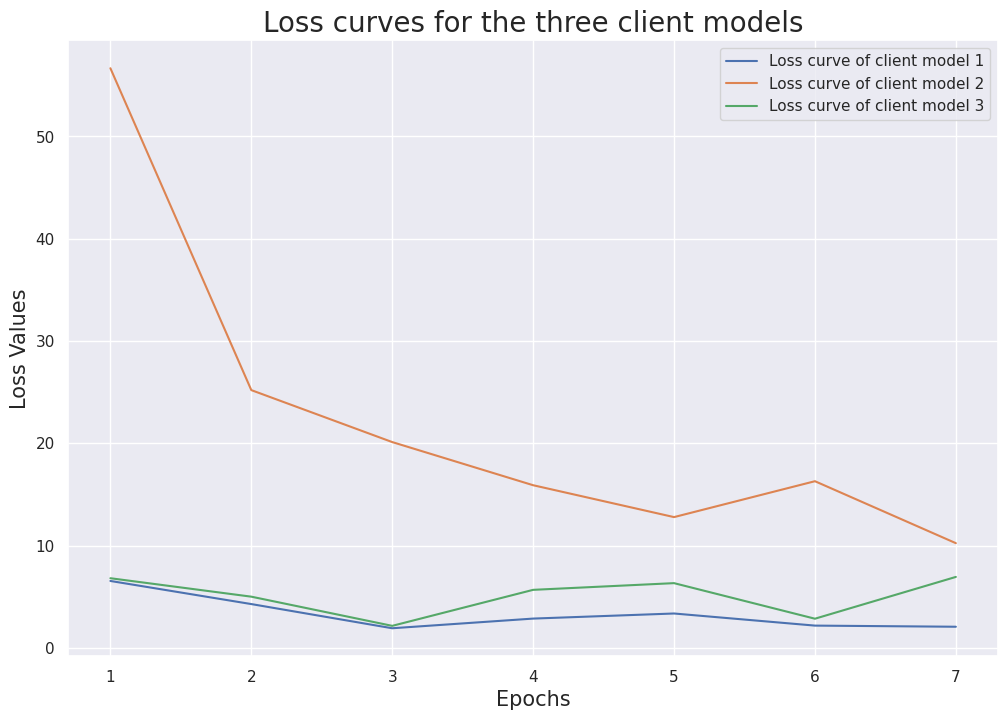

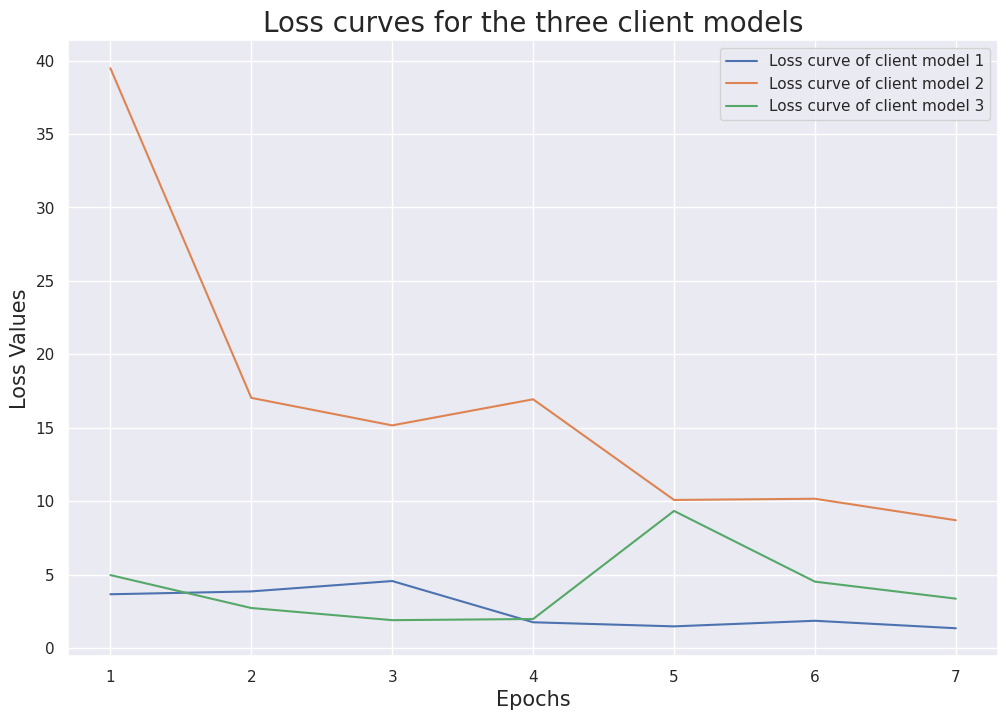

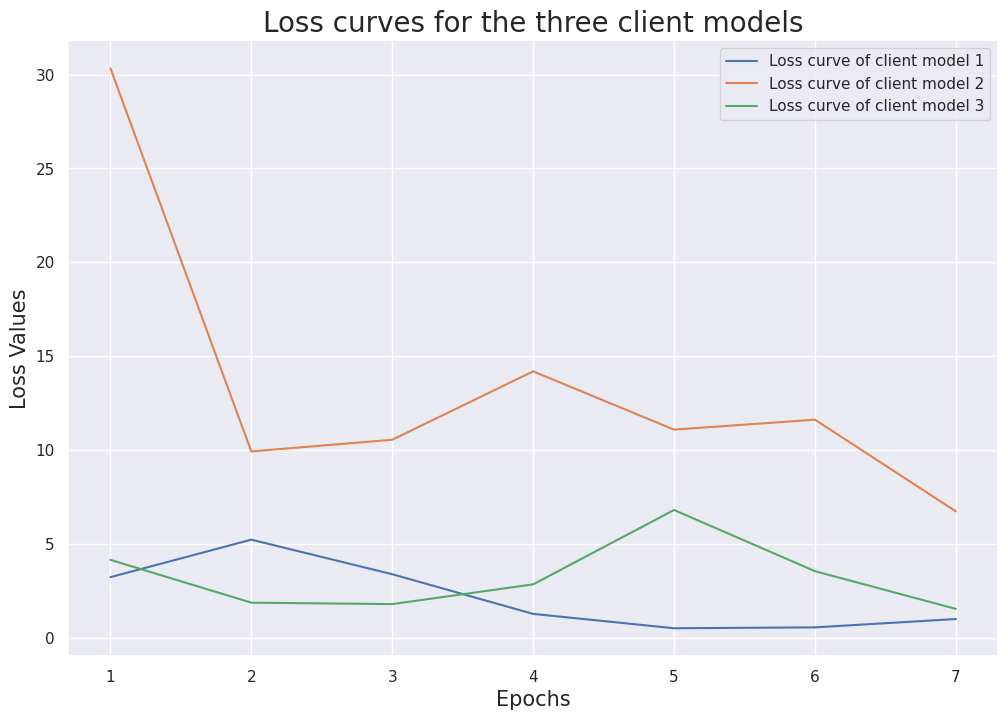

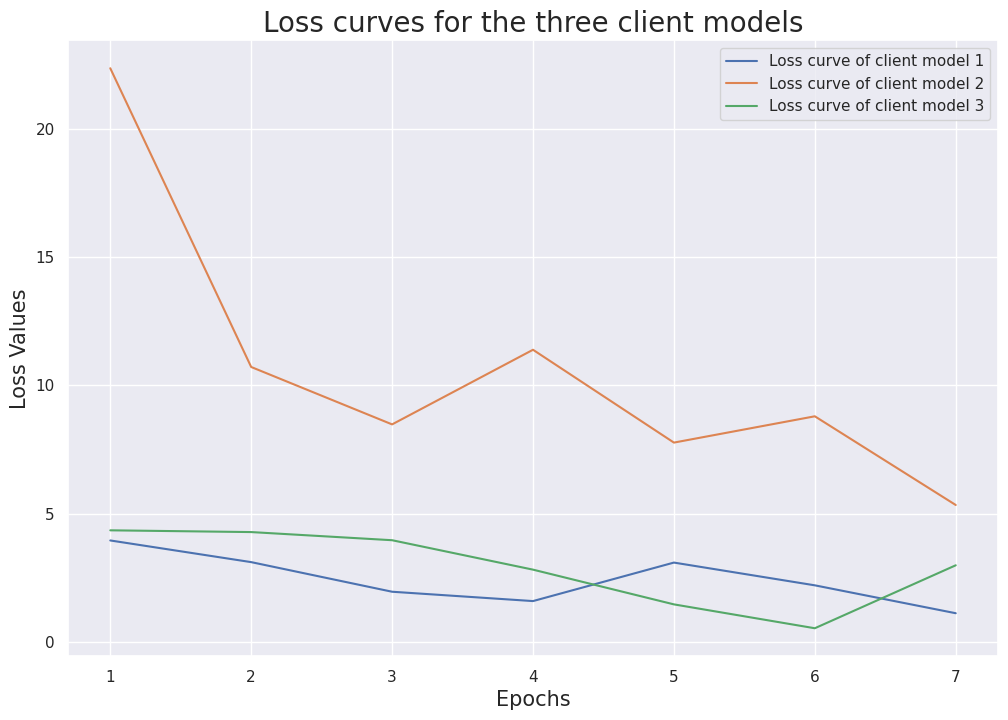

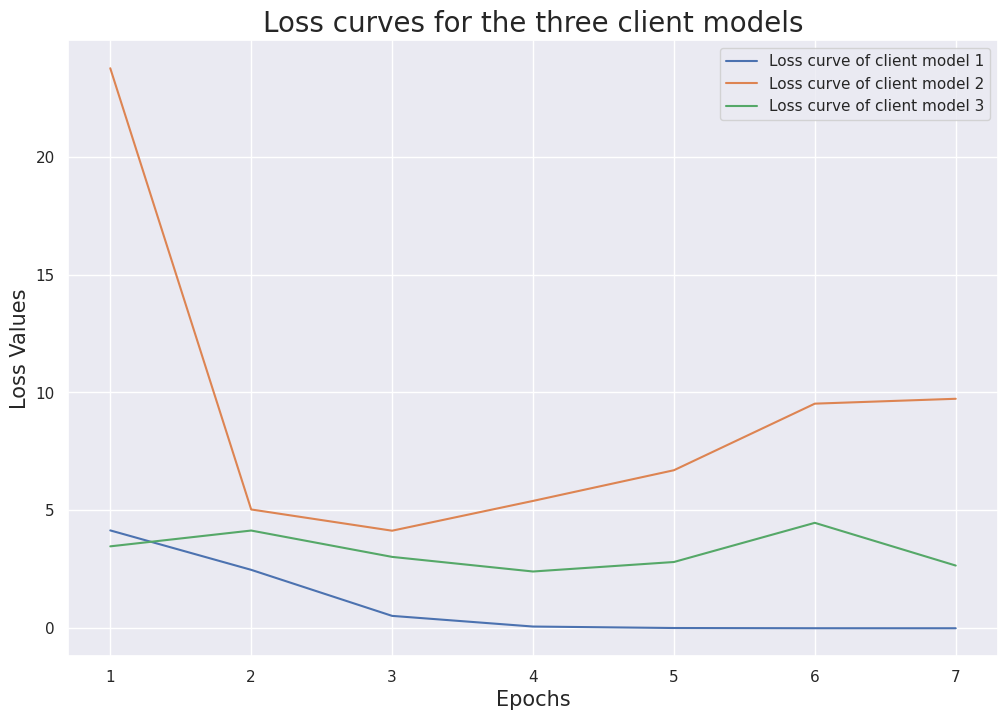

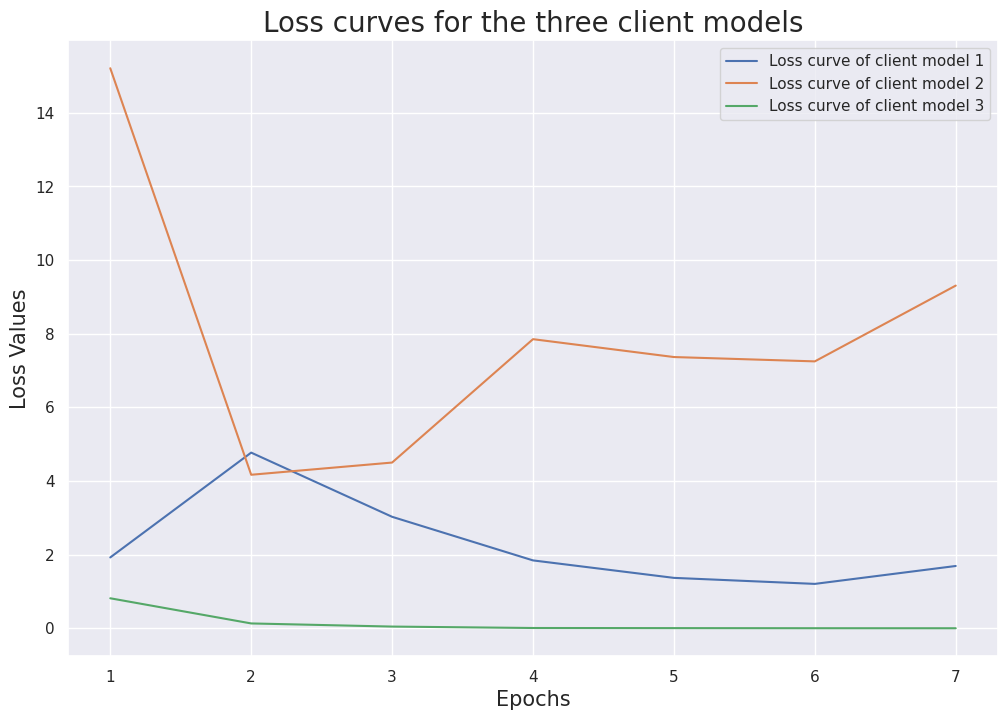

In [74]:

for i in range(num_rounds):
  loss = 0
  list_loss=[]
  for i in range(num_clients):
      if i==0:
        print('Training the model with MNIST dataset')
      elif i==1:
        print('Training the model with SVHN dataset')
      elif i==2:
        print('Training the model with Colored MNIST dataset')
      loss_c ,l= update_client(client_models[i], opt[i], train_loader[i], num_epochs=epochs)
      loss+=loss_c
      list_loss.append(l)

  plot_loss(list_loss[0],list_loss[1],list_loss[2],epochs)

  #Aggregating the loss at the client server
  aggregate_loss(central_server,client_models)


In [75]:
torch.save(client_models[0].state_dict(),'/content/drive/MyDrive/DAI_PA3/client_model1.pth')
torch.save(client_models[1].state_dict(),'/content/drive/MyDrive/DAI_PA3/client_model2.pth')
torch.save(client_models[2].state_dict(),'/content/drive/MyDrive/DAI_PA3/client_model3.pth')
torch.save(central_server.state_dict(),'/content/drive/MyDrive/DAI_PA3/central_server.pth')


In [76]:
def plot_cwacc(l1,l2,l3,classes):
  x=np.arange(classes)
  plt.figure(figsize=(12,8))
  sns.set_context('notebook')
  plt.plot(x,l1,label='Classwise Accuracy of client model 1')
  plt.plot(x,l2,label='Classwise Accuracy of client model 2')
  plt.plot(x,l3,label='Classwise Accuracy of client model 3')
  plt.legend()
  plt.xlabel('Classes',fontsize=15)
  plt.ylabel('Classwise Accuracy',fontsize=15)
  plt.xticks(range(0,classes))
  plt.title('Classwise Accuracy for the three client models',fontsize=20)

###Classwise accuracy scores at respective client side

###MNIST at client 1

In [77]:
test_loss_1, overall_acc_1, classwise_acc_1,confusion_matrix_1 = test(client_models[0], test_loader[0],10)

###SVHN at client *2*

In [78]:
test_loss_2, overall_acc_2, classwise_acc_2,confusion_matrix_2 = test(client_models[1], test_loader[1],10)

###Colored MNIST at client 3

In [79]:
test_loss_3, overall_acc_3, classwise_acc_3,confusion_matrix_3 = test(client_models[2], test_loader[2],10)

In [80]:
print('Overall Accuracy of client server 1:',overall_acc_1*100,'%')

Overall Accuracy of client server 1: 98.44000000000001 %


In [81]:
print('Overall Accuracy of client server 2:',overall_acc_2*100,'%')

Overall Accuracy of client server 2: 59.74 %


In [82]:
print('Overall Accuracy of client server 3:',overall_acc_3*100,'%')

Overall Accuracy of client server 3: 96.39999999999999 %


In [83]:
print('Classwise Accuracy of client server 1:')
for i in range(len(classwise_acc_1)):
  print(f'For class {i}: ',classwise_acc_1[i]*100,'%')

Classwise Accuracy of client server 1:
For class 0:  98.55371900826447 %
For class 1:  98.95833333333334 %
For class 2:  98.71323529411765 %
For class 3:  99.36842105263159 %
For class 4:  99.375 %
For class 5:  98.86877828054298 %
For class 6:  98.78048780487805 %
For class 7:  97.80439121756487 %
For class 8:  97.6878612716763 %
For class 9:  96.30390143737166 %


In [84]:
print('Classwise Accuracy of client server 2:')
for i in range(len(classwise_acc_2)):
  print(f'For class {i}: ',classwise_acc_2[i]*100,'%')

Classwise Accuracy of client server 2:
For class 0:  58.35866261398176 %
For class 1:  92.07622868605817 %
For class 2:  55.35714285714286 %
For class 3:  37.32638888888889 %
For class 4:  57.668711656441715 %
For class 5:  57.17592592592593 %
For class 6:  57.06666666666666 %
For class 7:  47.61904761904761 %
For class 8:  49.21630094043887 %
For class 9:  46.10591900311526 %


In [85]:
print('Classwise Accuracy of client server 3:')
for i in range(len(classwise_acc_3)):
  print(f'For class {i}: ',classwise_acc_3[i]*100,'%')

Classwise Accuracy of client server 3:
For class 0:  97.54098360655738 %
For class 1:  99.44341372912801 %
For class 2:  97.71863117870723 %
For class 3:  96.98189134808854 %
For class 4:  96.0167714884696 %
For class 5:  95.37037037037037 %
For class 6:  96.31147540983606 %
For class 7:  96.85767097966729 %
For class 8:  92.84294234592446 %
For class 9:  94.49901768172889 %


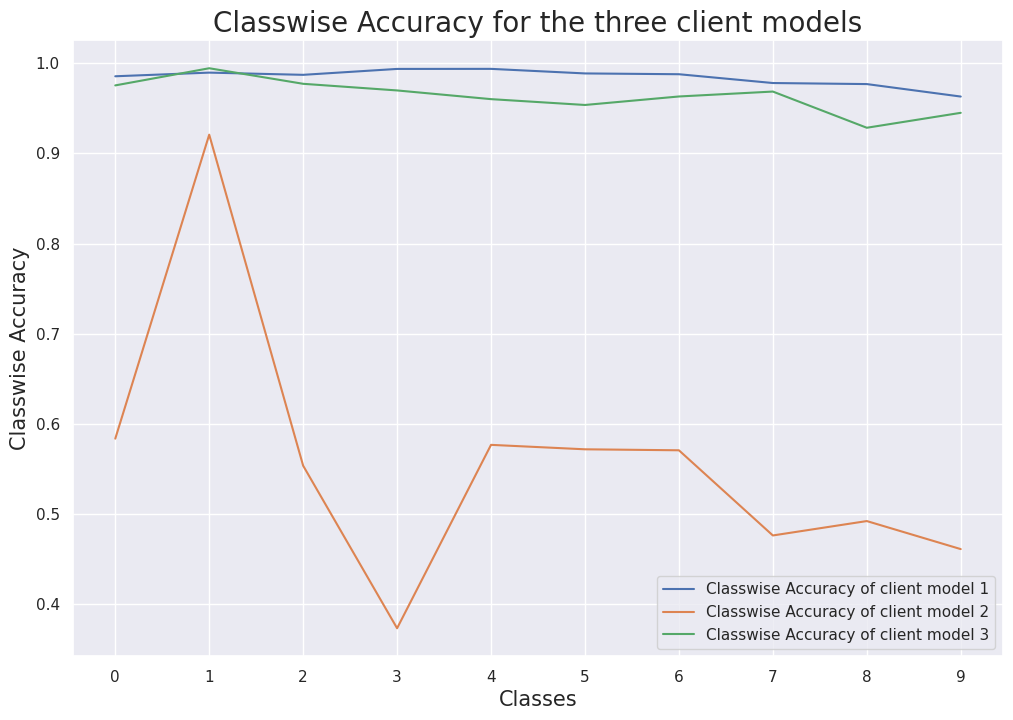

In [86]:
plot_cwacc(classwise_acc_1,classwise_acc_2,classwise_acc_3,10)

##Plotting the confusion matrix for all the three clients on their respective dataset

In [87]:
classes=np.arange(10)

For Client Model 1


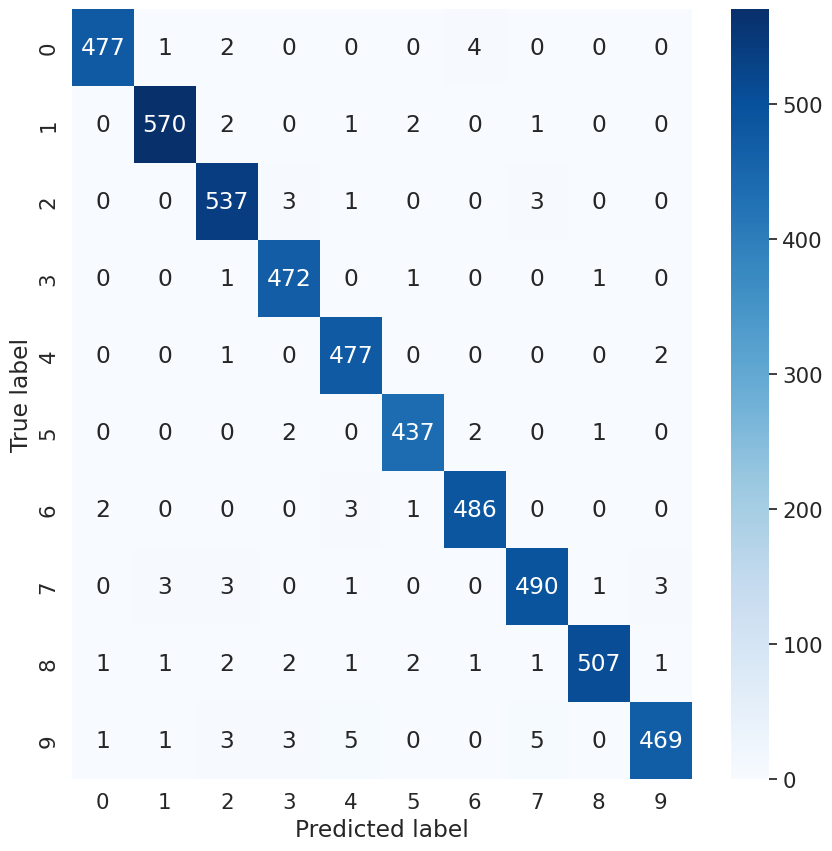

In [88]:
print('For Client Model 1')
plot_cm(confusion_matrix_1,classes)

For Client Model 2


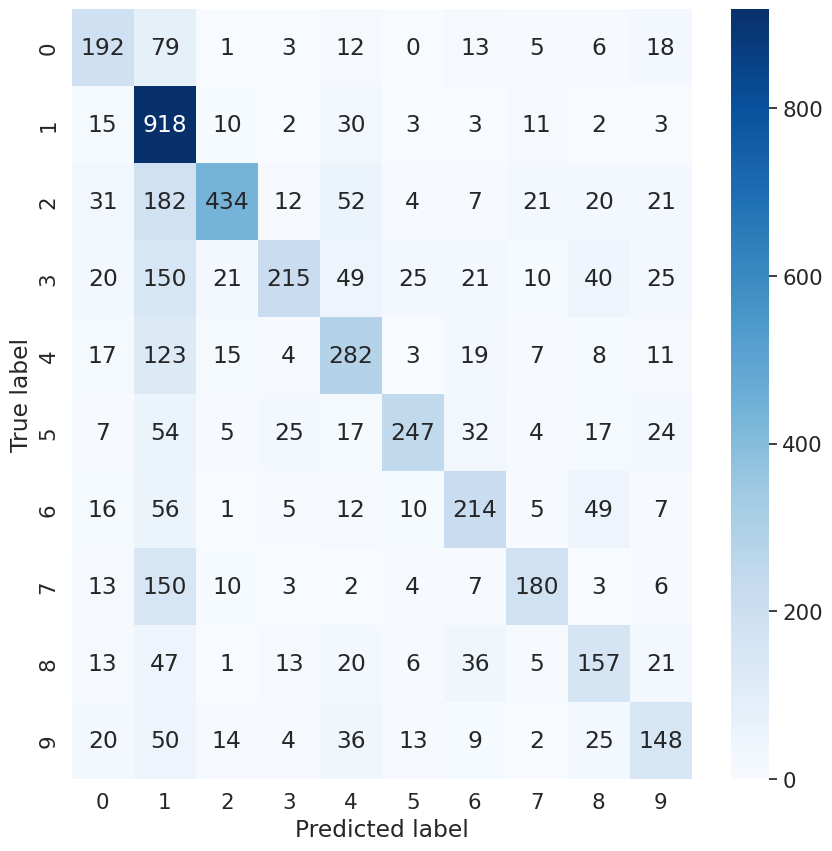

In [89]:
print('For Client Model 2')
plot_cm(confusion_matrix_2,classes)

For Client Model 3


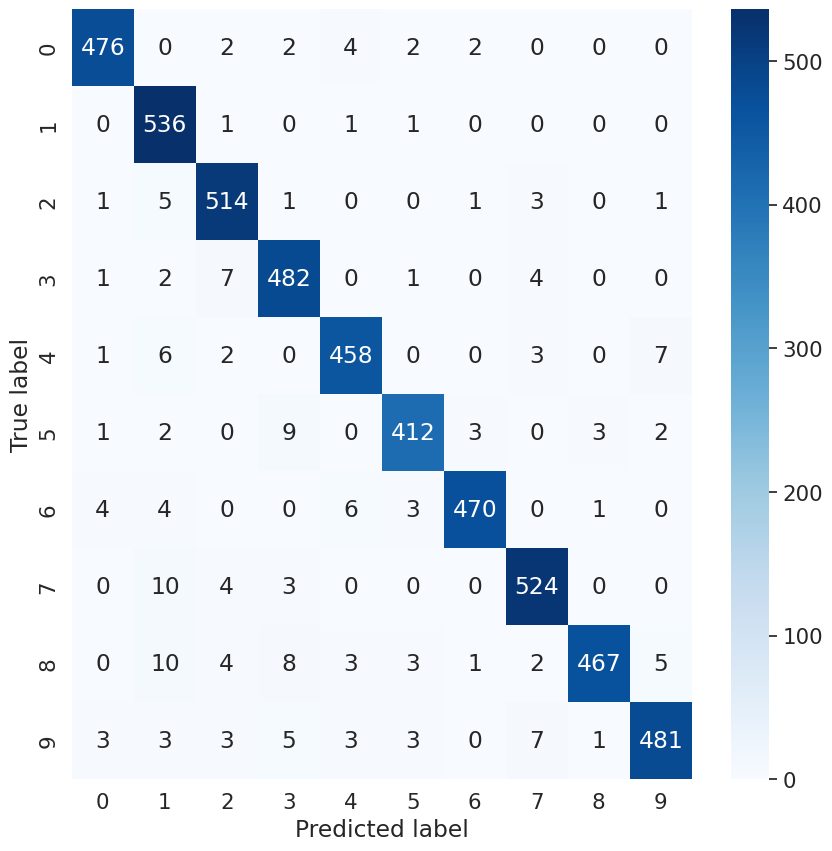

In [90]:
print('For Client Model 3')
plot_cm(confusion_matrix_3,classes)

##Classwise accuracy scores at the central_server

###MNIST 

In [91]:
test_loss_1, overall_acc_1, classwise_acc_1,confusion_matrix_1 = test(central_server, test_loader[0],10)

###SVHN

In [92]:
test_loss_2, overall_acc_2, classwise_acc_2,confusion_matrix_2 = test(central_server, test_loader[1],10)

###Colored MNIST

In [93]:
test_loss_3, overall_acc_3, classwise_acc_3,confusion_matrix_3 = test(central_server, test_loader[2],10)

In [94]:
print('Accuracy of central server on MNIST:',overall_acc_1*100,'%')

Accuracy of central server on MNIST: 98.44000000000001 %


In [95]:
print('Accuracy of central server on SVHN:',overall_acc_2*100,'%')

Accuracy of central server on SVHN: 59.74 %


In [96]:
print('Accuracy of central server on Coloured MNIST:',overall_acc_3*100,'%')

Accuracy of central server on Coloured MNIST: 96.39999999999999 %


In [97]:
print('Classwise Accuracy of central server on MNIST:')
for i in range(len(classwise_acc_1)):
  print(f'For class {i}: ',classwise_acc_1[i]*100,'%')

Classwise Accuracy of central server on MNIST:
For class 0:  98.55371900826447 %
For class 1:  98.95833333333334 %
For class 2:  98.71323529411765 %
For class 3:  99.36842105263159 %
For class 4:  99.375 %
For class 5:  98.86877828054298 %
For class 6:  98.78048780487805 %
For class 7:  97.80439121756487 %
For class 8:  97.6878612716763 %
For class 9:  96.30390143737166 %


In [98]:
print('Classwise Accuracy of central server on SVHN:')
for i in range(len(classwise_acc_2)):
  print(f'For class {i}: ',classwise_acc_2[i]*100,'%')

Classwise Accuracy of central server on SVHN:
For class 0:  58.35866261398176 %
For class 1:  92.07622868605817 %
For class 2:  55.35714285714286 %
For class 3:  37.32638888888889 %
For class 4:  57.668711656441715 %
For class 5:  57.17592592592593 %
For class 6:  57.06666666666666 %
For class 7:  47.61904761904761 %
For class 8:  49.21630094043887 %
For class 9:  46.10591900311526 %


In [99]:
print('Classwise Accuracy of central server on Coloured MNIST:')
for i in range(len(classwise_acc_3)):
  print(f'For class {i}: ',classwise_acc_3[i]*100,'%')

Classwise Accuracy of central server on Coloured MNIST:
For class 0:  97.54098360655738 %
For class 1:  99.44341372912801 %
For class 2:  97.71863117870723 %
For class 3:  96.98189134808854 %
For class 4:  96.0167714884696 %
For class 5:  95.37037037037037 %
For class 6:  96.31147540983606 %
For class 7:  96.85767097966729 %
For class 8:  92.84294234592446 %
For class 9:  94.49901768172889 %


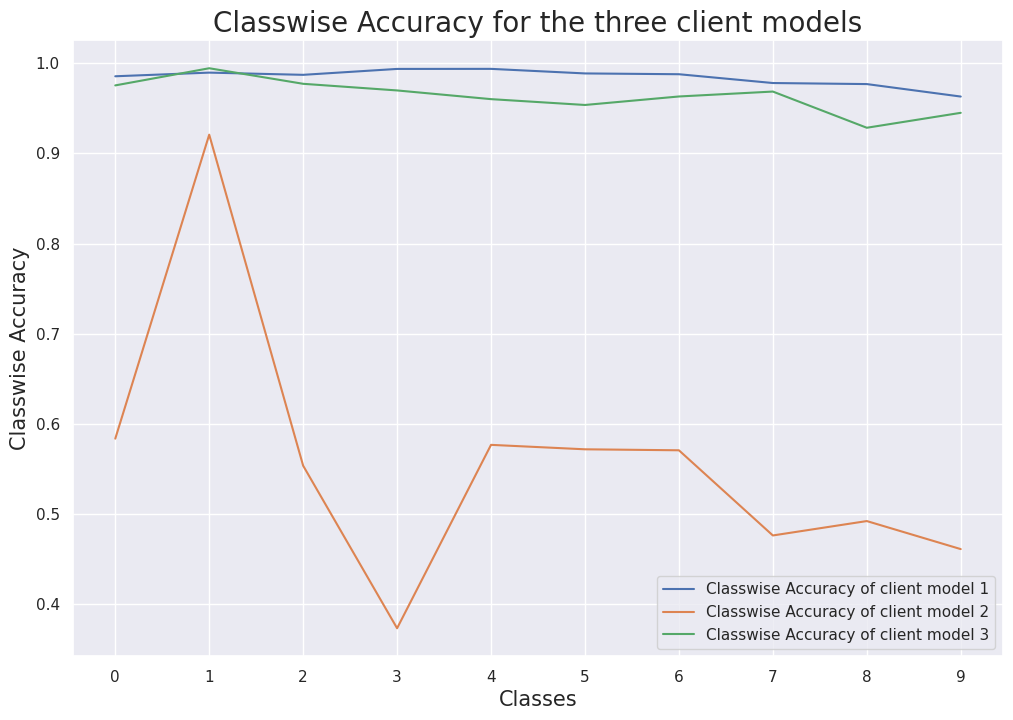

In [100]:
plot_cwacc(classwise_acc_1,classwise_acc_2,classwise_acc_3,10)

##Plotting the confusion matrix for all the three datasets on the central_server

In [101]:
classes=np.arange(10)

For Client Model 1


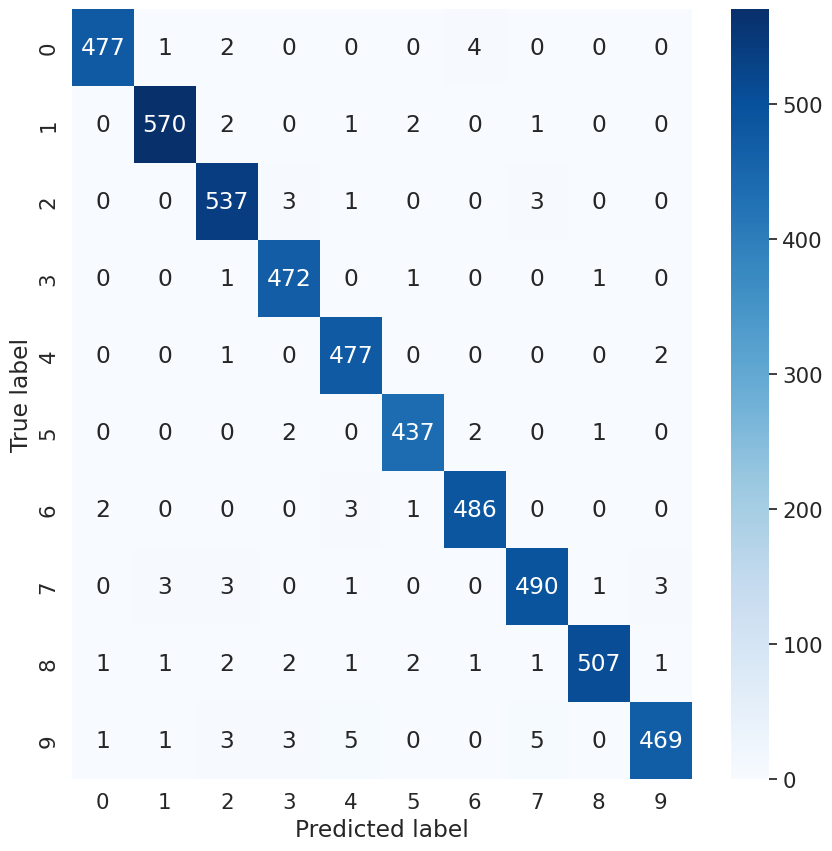

In [102]:
print('For Client Model 1')
plot_cm(confusion_matrix_1,classes)

For Client Model 2


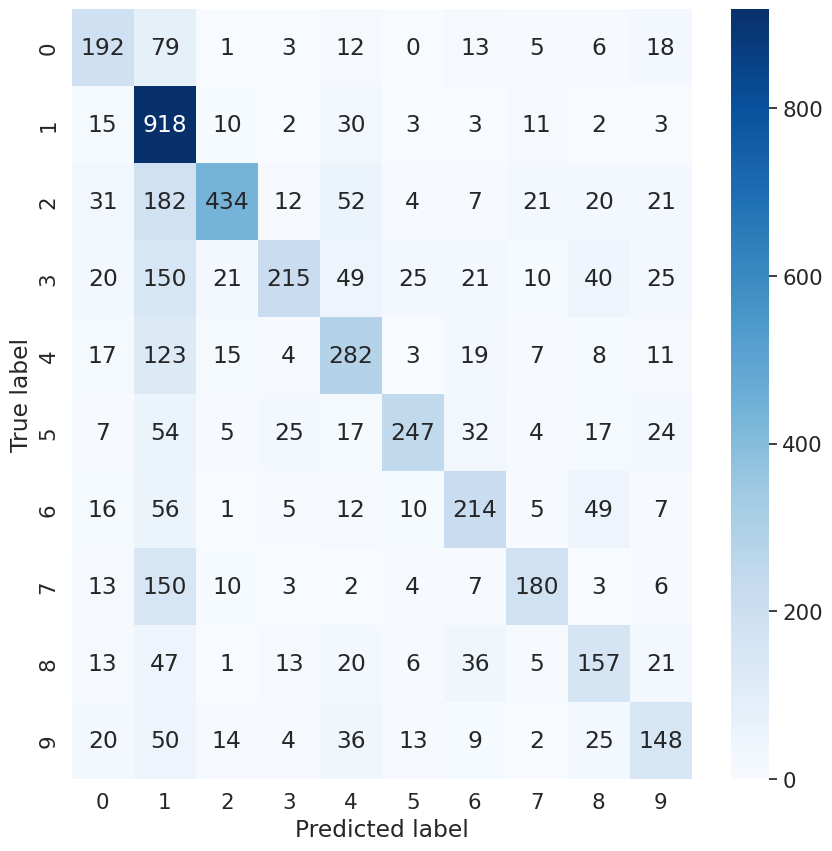

In [103]:
print('For Client Model 2')
plot_cm(confusion_matrix_2,classes)

For Client Model 3


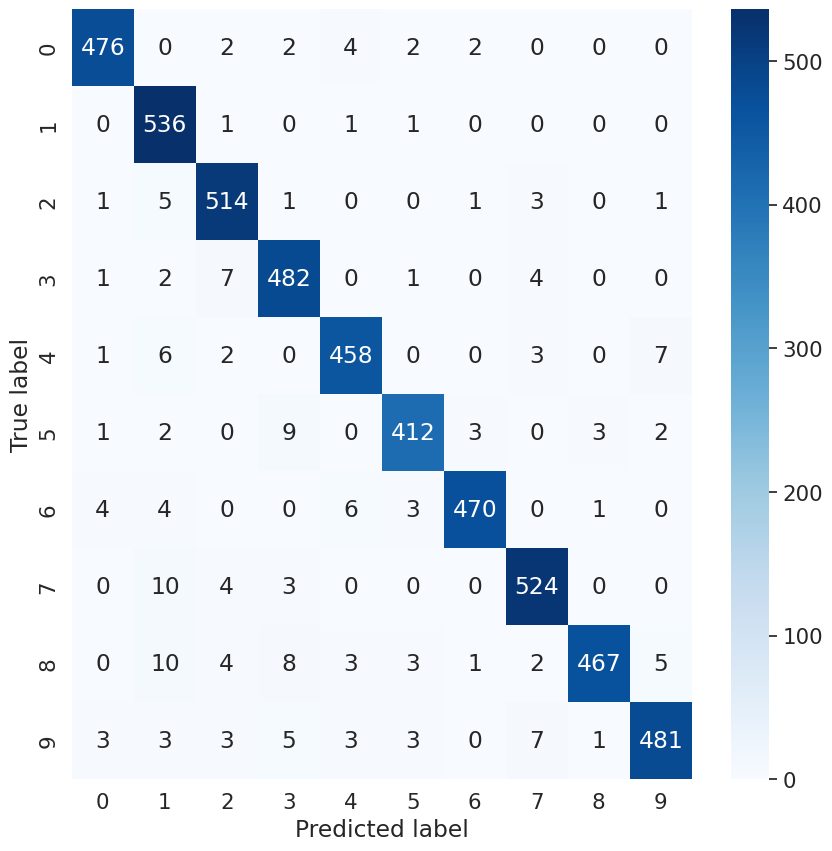

In [104]:
print('For Client Model 3')
plot_cm(confusion_matrix_3,classes)

##Reporting the overall classification accuracy and the confusion matrix

###We will do this by testing on the central_server on the combination of all three datasets

In [105]:
test_loss, overall_acc, classwise_acc,confusion_matrix = test(central_server, testloader,10)

In [106]:
print("Overall Accuracy: ",overall_acc*100,'%')

Overall Accuracy:  84.86 %


In [107]:
print('Overall Classwise Accuracy:')
for i in range(len(classwise_acc)):
  print(f'For class {i}: ',classwise_acc[i]*100,'%')

Overall Classwise Accuracy:
For class 0:  88.00922367409684 %
For class 1:  95.83333333333334 %
For class 2:  80.09708737864078 %
For class 3:  75.51679586563309 %
For class 4:  84.16320885200554 %
For class 5:  83.92036753445635 %
For class 6:  86.34686346863468 %
For class 7:  84.08450704225352 %
For class 8:  84.3400447427293 %
For class 9:  83.37129840546697 %


Overall Confusion Matrix


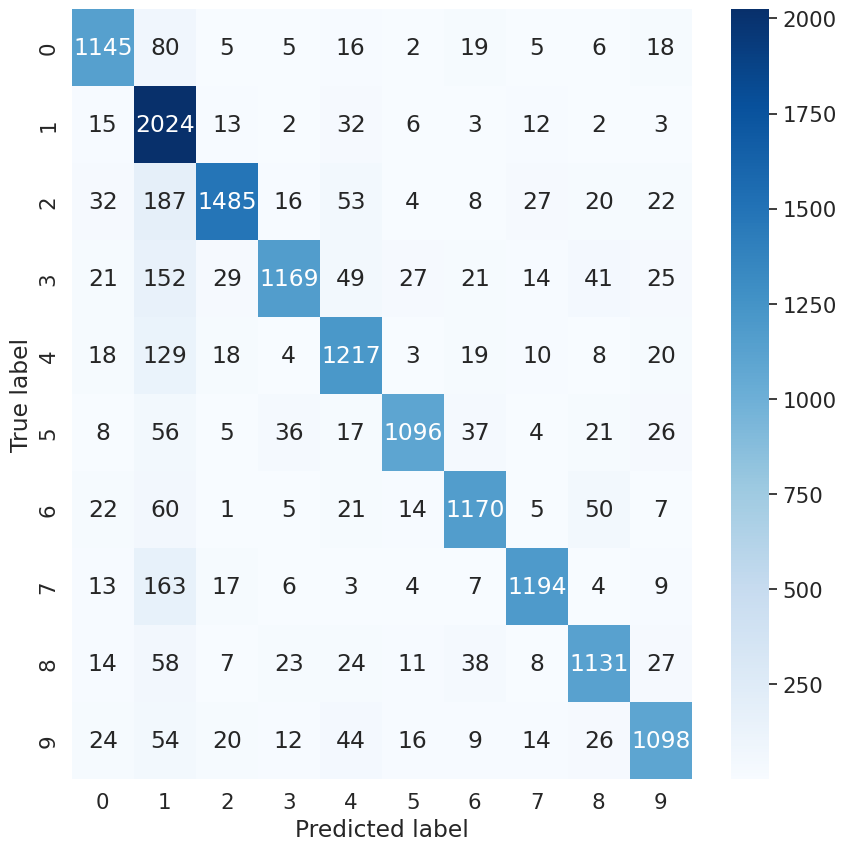

In [108]:
print('Overall Confusion Matrix')
plot_cm(confusion_matrix,classes)

##E.Compare the results of overall accuracy in federated setup with the baseline results calculated by combining all the datasets and training in non-federated setup. Do you observe any decrease/increase in accuracy for both the setups? State your answer with proper reasoning.       

In [109]:
import timeit

In [116]:
def train_nfd(model,optimizer,loader,epochs):
    train_a=[]
    train_l=[]
    start_time = timeit.default_timer()
    for epoch in range(epochs):
        train_loss = 0.0
        total=0
        correct=0
        for i, data in enumerate(loader, 0):
            inputs, labels = data
            inputs,labels=inputs.to(device),labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            
        print('====> Epoch: {} Average loss: {:.4f}, Accuracy : {:.3f}%'.format(
          epoch, train_loss / len(loader.dataset),100.*correct/total))
        train_a.append(100*correct/total)
        train_loss /= len(loader.dataset)
        train_l.append(train_loss)
    elapsed_time = timeit.default_timer() - start_time
    return train_l,train_a,elapsed_time

In [117]:
model_nfd=CNN().to(device)
optimizer_nfd=optim.Adam(model_nfd.parameters(), lr=0.001)
epochs=30

In [118]:
train_l,train_a,elapsed_time=train_nfd(model_nfd,optimizer_nfd,trainloader,epochs)

====> Epoch: 0 Average loss: 0.0198, Accuracy : 70.867%
====> Epoch: 1 Average loss: 0.0075, Accuracy : 86.170%
====> Epoch: 2 Average loss: 0.0056, Accuracy : 89.757%
====> Epoch: 3 Average loss: 0.0045, Accuracy : 91.490%
====> Epoch: 4 Average loss: 0.0040, Accuracy : 92.417%
====> Epoch: 5 Average loss: 0.0034, Accuracy : 93.543%
====> Epoch: 6 Average loss: 0.0031, Accuracy : 94.093%
====> Epoch: 7 Average loss: 0.0027, Accuracy : 94.880%
====> Epoch: 8 Average loss: 0.0024, Accuracy : 95.477%
====> Epoch: 9 Average loss: 0.0021, Accuracy : 96.003%
====> Epoch: 10 Average loss: 0.0019, Accuracy : 96.337%
====> Epoch: 11 Average loss: 0.0017, Accuracy : 96.697%
====> Epoch: 12 Average loss: 0.0016, Accuracy : 97.047%
====> Epoch: 13 Average loss: 0.0012, Accuracy : 97.553%
====> Epoch: 14 Average loss: 0.0012, Accuracy : 97.693%
====> Epoch: 15 Average loss: 0.0010, Accuracy : 98.097%
====> Epoch: 16 Average loss: 0.0009, Accuracy : 98.127%
====> Epoch: 17 Average loss: 0.0009, Acc

In [119]:
test_loss, overall_acc, classwise_acc,confusion_matrix=test(model_nfd,testloader,10)

In [120]:
print('Overall Accuracy: ',overall_acc*100,'%')

Overall Accuracy:  91.98666666666668 %


In [121]:
print('Overall Classwise Accuracy:')
for i in range(len(classwise_acc)):
  print(f'For class {i}: ',classwise_acc[i]*100,'%')

Overall Classwise Accuracy:
For class 0:  93.77401998462722 %
For class 1:  93.51325757575758 %
For class 2:  91.53182308522115 %
For class 3:  88.43669250645995 %
For class 4:  92.80774550484094 %
For class 5:  91.42419601837672 %
For class 6:  90.92250922509226 %
For class 7:  96.54929577464789 %
For class 8:  89.11260253542133 %
For class 9:  91.34396355353076 %


In [122]:
classes=np.arange(10)

Overall Confusion Matrix


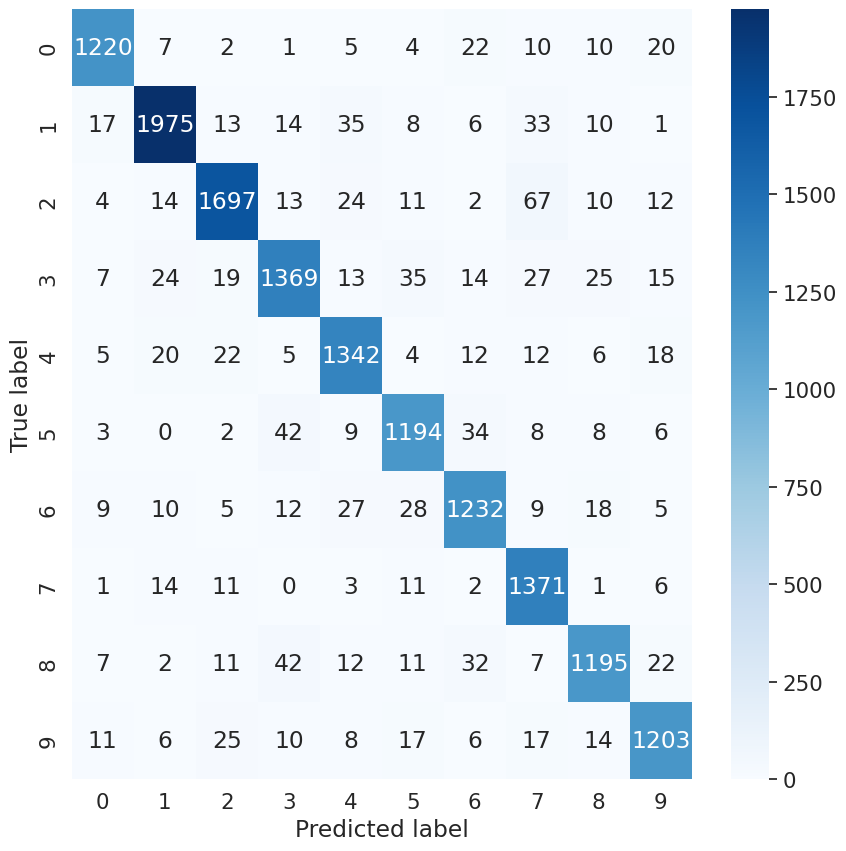

In [123]:
print('Overall Confusion Matrix')
plot_cm(confusion_matrix,classes)